In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", X_test.shape)
print("x_test shape:", y_test.shape)

x_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
y_test shape: (12630, 32, 32, 3)
x_test shape: (12630,)


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

X_train = X_train_gry
X_test = X_test_gry

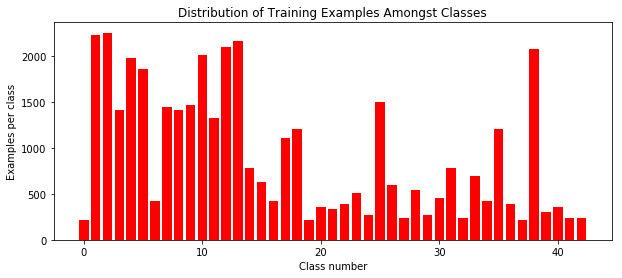

In [3]:
def draw_class_distribution(class_labels):
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8, color='red', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show() 
    
draw_class_distribution(y_train)

In [4]:
## Normalize the train and test datasets to (-1,1)

X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

-0.354179278547
-0.358215153428


In [5]:
import cv2

def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

### Augmentation,  Brightness, if the number of dataset less than 1000,   generate to 1000.

In [7]:
n_classes = len(np.unique(y_train))
print('X, y shapes:', X_train_normalized.shape, y_train.shape)


input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 1000:
        for i in range(1000 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_brightness(new_img)
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

X, y shapes: (39209, 32, 32, 1) (39209,)
0 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|----|----|----|--
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|----|----|-
15 : |----|----|----|----|----|----|----|-
16 : |----|----|----|----|----|----|----|----|----|----|----|--
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---
20 : |----|----|----|----|----|----|----|----|----|----|----|----|---
21 : |----|----|----|----|----|----|----|----|----|----|----|----|----|-
22 : |----|----|----|----|----|----|----|----|----|----|----|----|
23 : |----|----|----|----|----|----|----|----|----|---
24 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|--
25 : 
26 : |----|----|----|----|----|----|----|----
27 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
28 : |----|----|----|----|----|----|--

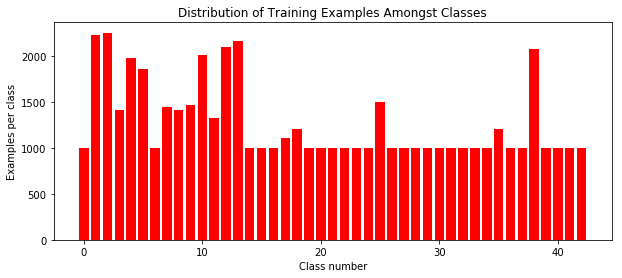

In [8]:
draw_class_distribution( y_train)

In [9]:
## Shuffle the training dataset

from sklearn.utils import shuffle

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
print("Old X_train size:",len(X_train))
print("New X_train size:",len(X_train_normalized))
print("New Y_train size:",len(y_train))

Old X_train size: 39209
New X_train size: 54710
New Y_train size: 54710


In [10]:
import tensorflow as tf

EPOCHS = 40
BATCH_SIZE = 100

In [11]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)
print("X_train_normalized size:",len(X_train_normalized))
print("X_train_split size:",len(X_train_split))
print("X_val size:",len(X_val_split))

X_train_normalized size: 54710
X_train_split size: 43768
X_val size: 10942


In [12]:
from tensorflow.contrib.layers import flatten

def LeNet2_ICGIP(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    #print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    #print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    #print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    #print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    #x = tf.nn.relu(x)

    # TODO: Layer 5: Fully Connected. Input = 120. Output = 84.
    #W5 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    #b5 = tf.Variable(tf.zeros(84)) 
    #x = tf.add(tf.matmul(x, W5), b5)
    
    # TODO: Activation.
    #x = tf.nn.relu(x)

    # TODO: Layer 6: Fully Connected. Input = 84. Output = 43.
    #W6 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    #b6 = tf.Variable(tf.zeros(43)) 
    #logits = tf.add(tf.matmul(x, W6), b6)
    
    return logits

In [13]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)
rate = 0.001

In [14]:
logits = LeNet2_ICGIP(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
print(X_train_normalized.shape)


(54710, 32, 32, 1)


In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_split)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_split[offset:end], y_train_split[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_val_split, y_val_split)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet2_rbrightness')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.936

EPOCH 2 ...
Validation Accuracy = 0.969

EPOCH 3 ...
Validation Accuracy = 0.983

EPOCH 4 ...
Validation Accuracy = 0.984

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.991

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.991

EPOCH 10 ...
Validation Accuracy = 0.993

EPOCH 11 ...
Validation Accuracy = 0.993

EPOCH 12 ...
Validation Accuracy = 0.991

EPOCH 13 ...
Validation Accuracy = 0.993

EPOCH 14 ...
Validation Accuracy = 0.994

EPOCH 15 ...
Validation Accuracy = 0.993

EPOCH 16 ...
Validation Accuracy = 0.993

EPOCH 17 ...
Validation Accuracy = 0.994

EPOCH 18 ...
Validation Accuracy = 0.994

EPOCH 19 ...
Validation Accuracy = 0.994

EPOCH 20 ...
Validation Accuracy = 0.994

EPOCH 21 ...
Validation Accuracy = 0.993

EPOCH 22 ...
Validation Accuracy = 0.995

EPOCH 23 ...
Validation Accuracy = 0.995

EPOCH 24 ...
Validation Accura

In [21]:
# load `lenet_split.meta` model to test `X_test`
# Check the test time for the 'lenet2_rtranslate'
#import time
import time
t=time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('lenet2_rbrightness.meta')
    saver2.restore(sess, "lenet2_rbrightness")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.4f}".format(test_accuracy))
t2=time.time()
print(round(t2-t,2),'Seconds to test...')

INFO:tensorflow:Restoring parameters from lenet2_rbrightness
Test Set Accuracy = 0.9432
1.52 Seconds to test...
